In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import skimage
from skimage.transform import resize
from skimage.io import imread
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization,\
    Activation, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
#Augmentation

In [3]:
def flip(img, msk):
    img_o = np.flip(img, axis=1)
    msk_o = np.flip(msk, axis=1)
    return img_o, msk_o

def rotate_A(img, msk):
    angle = np.random.choice((4, 6, 8, 10, 12, 14, 16, 18, 20))
    img_o = skimage.transform.rotate(img, angle, resize=False, preserve_range=True, mode='symmetric')
    msk_o = skimage.transform.rotate(msk, angle, resize=False, preserve_range=True, mode='symmetric')
    return img_o, msk_o

def rotate_B(img, msk):
    angle = np.random.choice((-20, -18, -16, -14, -12, -10, -8, -6, -4))
    img_o = skimage.transform.rotate(img, angle, resize=False, preserve_range=True, mode='symmetric')
    msk_o = skimage.transform.rotate(msk, angle, resize=False, preserve_range=True, mode='symmetric')
    return img_o, msk_o

def zoom(img, msk):

    zoom_factor = np.random.choice((1.2, 1.5, 1.8, 2, 2.2, 2.5))
    h, w = img.shape[:2]

    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))

    img = resize(img, (zh, zw), preserve_range=True, mode='symmetric')
    msk = resize(msk, (zh, zw), preserve_range=True, mode='symmetric')
    region = np.random.choice((0, 1, 2, 3, 4))

    if zoom_factor <= 1:
        outimg = img
        outmsk = msk

    else:
        
        if region == 0:
            outimg = img[0:h, 0:w]
            outmsk = msk[0:h, 0:w]
        if region == 1:
            outimg = img[0:h, zw - w:zw]
            outmsk = msk[0:h, zw - w:zw]
        if region == 2:
            outimg = img[zh - h:zh, 0:w]
            outmsk = msk[zh - h:zh, 0:w]
        if region == 3:
            outimg = img[zh - h:zh, zw - w:zw]
            outmsk = msk[zh - h:zh, zw - w:zw]
        if region == 4:
            marh = h // 2
            marw = w // 2
            outimg = img[(zh // 2 - marh):(zh // 2 + marh), (zw // 2 - marw):(zw // 2 + marw)]
            outmsk = msk[(zh // 2 - marh):(zh // 2 + marh), (zw // 2 - marw):(zw // 2 + marw)]

    img_o = resize(outimg, (h, w), preserve_range=True, mode='symmetric')
    msk_o = resize(outmsk, (h, w), preserve_range=True, mode='symmetric')
    return img_o, msk_o



In [4]:
#ADAMLearningRateTracker

In [5]:
import keras
import keras.backend as K
from tqdm import tqdm

class ADAMLearningRateTracker(keras.callbacks.Callback):

    def __init__(self, end_lr):
        super(ADAMLearningRateTracker, self).__init__()
        self.end_lr = end_lr

    def on_epoch_end(self, epoch, logs={}): 
        optimizer = self.model.optimizer
        t = K.cast(optimizer.iterations, K.floatx()) + 1
        lr_t = K.eval(optimizer.lr * (K.sqrt(1. - K.pow(optimizer.beta_2, t)) /
                                      (1. - K.pow(optimizer.beta_1, t))))
        print('\n***The last Actual Learning rate in this epoch is:', lr_t,'***\n')
        print('\n***The last Basic Learning rate in this epoch is:', K.eval(optimizer.lr), '***\n')
        
        if K.eval(optimizer.lr) <= self.end_lr:
            print("training is finished")
            self.model.stop_training = True



Using TensorFlow backend.


In [6]:
# getting input images name to read them

In [7]:
def get_input_image_names(list_names, directory_name, if_train=True):
    list_img = []
    list_msk = []
    list_test_ids = []

    for filenames in tqdm(list_names['name'], miniters=1000):
        nred = 'red_' + filenames
        nblue = 'blue_' + filenames
        ngreen = 'green_' + filenames
        nnir = 'nir_' + filenames

        if if_train:
            dir_type_name = "train"
            fl_img = []
            nmask = 'gt_' + filenames
            fl_msk = directory_name + '/train_gt/' + '{}.TIF'.format(nmask)
            list_msk.append(fl_msk)

        else:
            dir_type_name = "test"
            fl_img = []
            fl_id = '{}.TIF'.format(filenames)
            list_test_ids.append(fl_id)

        fl_img_red = directory_name + '/' + dir_type_name + '_red/' + '{}.TIF'.format(nred)
        fl_img_green = directory_name + '/' + dir_type_name + '_green/' + '{}.TIF'.format(ngreen)
        fl_img_blue = directory_name + '/' + dir_type_name + '_blue/' + '{}.TIF'.format(nblue)
        fl_img_nir = directory_name + '/' + dir_type_name + '_nir/' + '{}.TIF'.format(nnir)
        fl_img.append(fl_img_red)
        fl_img.append(fl_img_green)
        fl_img.append(fl_img_blue)
        fl_img.append(fl_img_nir)

        list_img.append(fl_img)

    if if_train:
        return list_img, list_msk
    else:
        return list_img, list_test_ids


In [8]:
#Batch generation for training, validation & testing

In [9]:
def mybatch_generator_train(zip_list, img_rows, img_cols, batch_size, shuffle=True, max_possible_input_value=65536):
    number_of_batches = np.ceil(len(zip_list) / batch_size)
    if shuffle:
        random.shuffle(zip_list)
    counter = 0

    while True:
        if shuffle:
            random.shuffle(zip_list)

        batch_files = zip_list[batch_size * counter:batch_size * (counter + 1)]
        image_list = []
        mask_list = []

        for file, mask in batch_files:

            image_red = imread(file[0])
            image_green = imread(file[1])
            image_blue = imread(file[2])
            image_nir = imread(file[3])

            mask = imread(mask)

            image = np.stack((image_red, image_green, image_blue, image_nir), axis=-1)

            image = resize(image, (img_rows, img_cols), preserve_range=True, mode='symmetric')
            mask = resize(mask, (img_rows, img_cols), preserve_range=True, mode='symmetric')

            rnd_flip = np.random.randint(2, dtype=int)
            rnd_rotate_clk = np.random.randint(2, dtype=int)
            rnd_rotate_cclk = np.random.randint(2, dtype=int)
            rnd_zoom = np.random.randint(2, dtype=int)

            if rnd_flip == 1:
                image, mask = flip(image, mask)

            if rnd_rotate_clk == 1:
                image, mask = rotate_A(image, mask)

            if rnd_rotate_cclk == 1:
                image, mask = rotate_B(image, mask)

            if rnd_zoom == 1:
                image, mask = zoom (image, mask)

            mask = mask[..., np.newaxis]
            mask /= 255
            image /= max_possible_input_value
            image_list.append(image)
            mask_list.append(mask)

        counter += 1
        image_list = np.array(image_list)
        mask_list = np.array(mask_list)
        yield (image_list, mask_list)

        if counter == number_of_batches:
            if shuffle:
                random.shuffle(zip_list)
            counter = 0


def mybatch_generator_validation(zip_list, img_rows, img_cols, batch_size, shuffle=False, max_possible_input_value=65536):
    number_of_batches = np.ceil(len(zip_list) / batch_size)
    if shuffle:
        random.shuffle(zip_list)
    counter = 0

    while True:

        batch_files = zip_list[batch_size * counter:batch_size * (counter + 1)]
        image_list = []
        mask_list = []

        for file, mask in batch_files:
            image_red = imread(file[0])
            image_green = imread(file[1])
            image_blue = imread(file[2])
            image_nir = imread(file[3])

            mask = imread(mask)

            image = np.stack((image_red, image_green, image_blue, image_nir), axis=-1)

            image = resize(image, (img_rows, img_cols), preserve_range=True, mode='symmetric')
            mask = resize(mask, (img_rows, img_cols), preserve_range=True, mode='symmetric')

            mask = mask[..., np.newaxis]
            mask /= 255
            image /= max_possible_input_value
            image_list.append(image)
            mask_list.append(mask)

        counter += 1
        image_list = np.array(image_list)
        mask_list = np.array(mask_list)
        yield (image_list, mask_list)

        if counter == number_of_batches:
            counter = 0


def mybatch_generator_prediction(tstfiles, img_rows, img_cols, batch_size, max_possible_input_value=65536):
    number_of_batches = np.ceil(len(tstfiles) / batch_size)
    counter = 0

    while True:

        beg = batch_size * counter
        end = batch_size * (counter + 1)
        batch_files = tstfiles[beg:end]
        image_list = []

        for file in batch_files:

            image_red = imread(file[0])
            image_green = imread(file[1])
            image_blue = imread(file[2])
            image_nir = imread(file[3])

            image = np.stack((image_red, image_green, image_blue, image_nir), axis=-1)

            image = resize (image, ( img_rows, img_cols), preserve_range=True, mode='symmetric')


            image /= max_possible_input_value
            image_list.append(image)

        counter += 1
        # print('counter = ', counter)
        image_list = np.array(image_list)

        yield (image_list)

        if counter == number_of_batches:
            counter = 0



In [10]:
#losses

In [11]:
smooth = 0.0000001

def jacc_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) - intersection + smooth))


In [12]:
#Neural Network

In [13]:
def bn_relu(input_tensor):

    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)


def conv_block(input_tensor, filters, kernel_size):

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = tf.keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def bottom_conv_block(input_tensor, filters, kernel_size ):

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = Conv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = Conv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)

    x2 = Conv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = tf.keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bottom_bridge(input_tensor, filters, kernel_size):

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = tf.keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x

def upconv(ip_ct, ip_blk, ip_c, fltrs):
    
    up= concatenate([ip_ct, ip_blk], axis=3)
    
    x = Conv2D(fltrs, (3, 3), padding='same')(up)
    x = bn_relu(x)

    x = Conv2D(fltrs, (3, 3), padding='same')(x)
    x = bn_relu(x)
    
    x = tf.keras.layers.add([x, ip_c, ip_ct])
    x = Activation("relu")(x)

    return x

def bottom_upconv(ip_ct, ip_blk, ip_c, fltrs):
    
    up= concatenate([ip_ct, ip_blk], axis=3)
    
    x = Conv2D(fltrs, (3, 3), padding='same')(up)
    x = bn_relu(x)

    x = Conv2D(fltrs, (3, 3), padding='same')(x)
    x = bn_relu(x)

    x = Conv2D(fltrs, (3, 3), padding='same')(x)
    x = bn_relu(x)
    
    x = tf.keras.layers.add([x, ip_c, ip_ct])
    x = Activation("relu")(x) 
    
    return x

def block4(input_tensor1, input_tensor2 ,input_tensor3, input_tensor4, pure_ff):

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    for ix in range(15):
        if ix == 0:
            x4 = input_tensor4
        x4 = concatenate([x4, input_tensor4], axis=3)
    x4 = MaxPooling2D(pool_size=(16, 16))(x4)

    x = tf.keras.layers.add([x1, x2, x3, x4, pure_ff])
    x = Activation("relu")(x)
    return x


def block3(input_tensor1, input_tensor2, input_tensor3, pure_ff):

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    x = tf.keras.layers.add([x1, x2, x3, pure_ff])
    x = Activation("relu")(x)
    return x


def block2(input_tensor1, input_tensor2, pure_ff):


    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    x = tf.keras.layers.add([x1, x2, pure_ff])
    x = Activation("relu")(x)
    return x


def block1(input_tensor1, pure_ff):


    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x = tf.keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x


def model_arch(input_rows=192, input_cols=192, num_of_channels=4, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = conv_block(conv, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = bottom_conv_block(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    bridge = bottom_bridge(pool5, 1024, (3, 3))

    convT6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    blk6 = block4(input_tensor1=conv4, input_tensor2=conv3, input_tensor3=conv2, input_tensor4=conv1, pure_ff=conv5)
    conv6= bottom_upconv(ip_ct=convT6, ip_blk=blk6, ip_c=conv5, fltrs=512)

    convT7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    blk7 = block3(input_tensor1=conv3, input_tensor2=conv2, input_tensor3=conv1, pure_ff=conv4)
    conv7= upconv(ip_ct= convT7, ip_blk= blk7, ip_c=conv4, fltrs=256)

    convT8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    blk8 = block2(input_tensor1=conv2, input_tensor2=conv1, pure_ff=conv3)
    conv8= upconv(ip_ct= convT8, ip_blk= blk8, ip_c=conv3, fltrs=128)

    convT9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    blk9 = block1(input_tensor1=conv1, pure_ff=conv2)
    conv9= upconv(ip_ct= convT9, ip_blk= blk9, ip_c=conv2, fltrs=64)
    
    convT10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9)
    conv10= upconv(ip_ct= convT10, ip_blk= conv1, ip_c=conv1, fltrs=32)

    rslt = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv10)

    return Model(inputs=[inputs], outputs=[rslt])


In [14]:
#compiling and fitting model to train

In [17]:
def train():
    model = model_arch(input_rows=in_rows,
                                       input_cols=in_cols,
                                       num_of_channels=num_of_channels,
                                       num_of_classes=num_of_classes)
    model.compile(optimizer=Adam(lr=starting_learning_rate), loss=jacc_coef, metrics=[jacc_coef])
    model.summary()

    model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
    lr_reducer = ReduceLROnPlateau(factor=decay_factor, cooldown=0, patience=patience, min_lr=end_learning_rate, verbose=1)
    csv_logger = CSVLogger(Name + '_log_1.log')

    train_img_split, val_img_split, train_msk_split, val_msk_split = train_test_split(train_img, train_msk,
                                                                                      test_size=val_ratio,
                                                                                      random_state=42, shuffle=True)

    if train_resume:
        model.load_weights(weights_path)
        print("\nTraining resumed...")
    else:
        print("\nTraining started from scratch... ")

    print("Input image size: ", (in_rows, in_cols))
    print("Number of input spectral bands: ", num_of_channels)
    print("Learning rate: ", starting_learning_rate)
    print("Batch size: ", batch_sz, "\n")

    logdir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    model.fit_generator(
        generator=mybatch_generator_train(list(zip(train_img_split, train_msk_split)), in_rows, in_cols, batch_sz, max_bit),
        steps_per_epoch=np.ceil(len(train_img_split) / batch_sz), epochs=max_num_epochs, verbose=2,
        validation_data=mybatch_generator_validation(list(zip(val_img_split, val_msk_split)), in_rows, in_cols, batch_sz, max_bit),
        validation_steps=np.ceil(len(val_img_split) / batch_sz),
        callbacks=[model_checkpoint, lr_reducer, ADAMLearningRateTracker(end_learning_rate), csv_logger,tensorboard])


GLOBAL_PATH = ''
TRAIN_FOLDER = os.path.join(GLOBAL_PATH, '38-Cloud_training')
TEST_FOLDER = os.path.join(GLOBAL_PATH, '38-Cloud_test')

in_rows = 192
in_cols = 192
num_of_channels = 4
num_of_classes = 1
starting_learning_rate = 1e-4
end_learning_rate = 1e-8
max_num_epochs = 200
val_ratio = 0.2
patience = 15
decay_factor = 0.7
batch_sz = 12
max_bit = 65535                                       # maximum gray level in landsat 8 images
Name = "Cloud-Detection"
weights_path = os.path.join(GLOBAL_PATH, Name + '.h5')


train_patches_csv_name = 'training_patches_38-Cloud.csv'
df_train_img = pd.read_csv(os.path.join(TRAIN_FOLDER, train_patches_csv_name))
train_img, train_msk = get_input_image_names(df_train_img, TRAIN_FOLDER, if_train=True)

In [ ]:
train_resume = False
train()

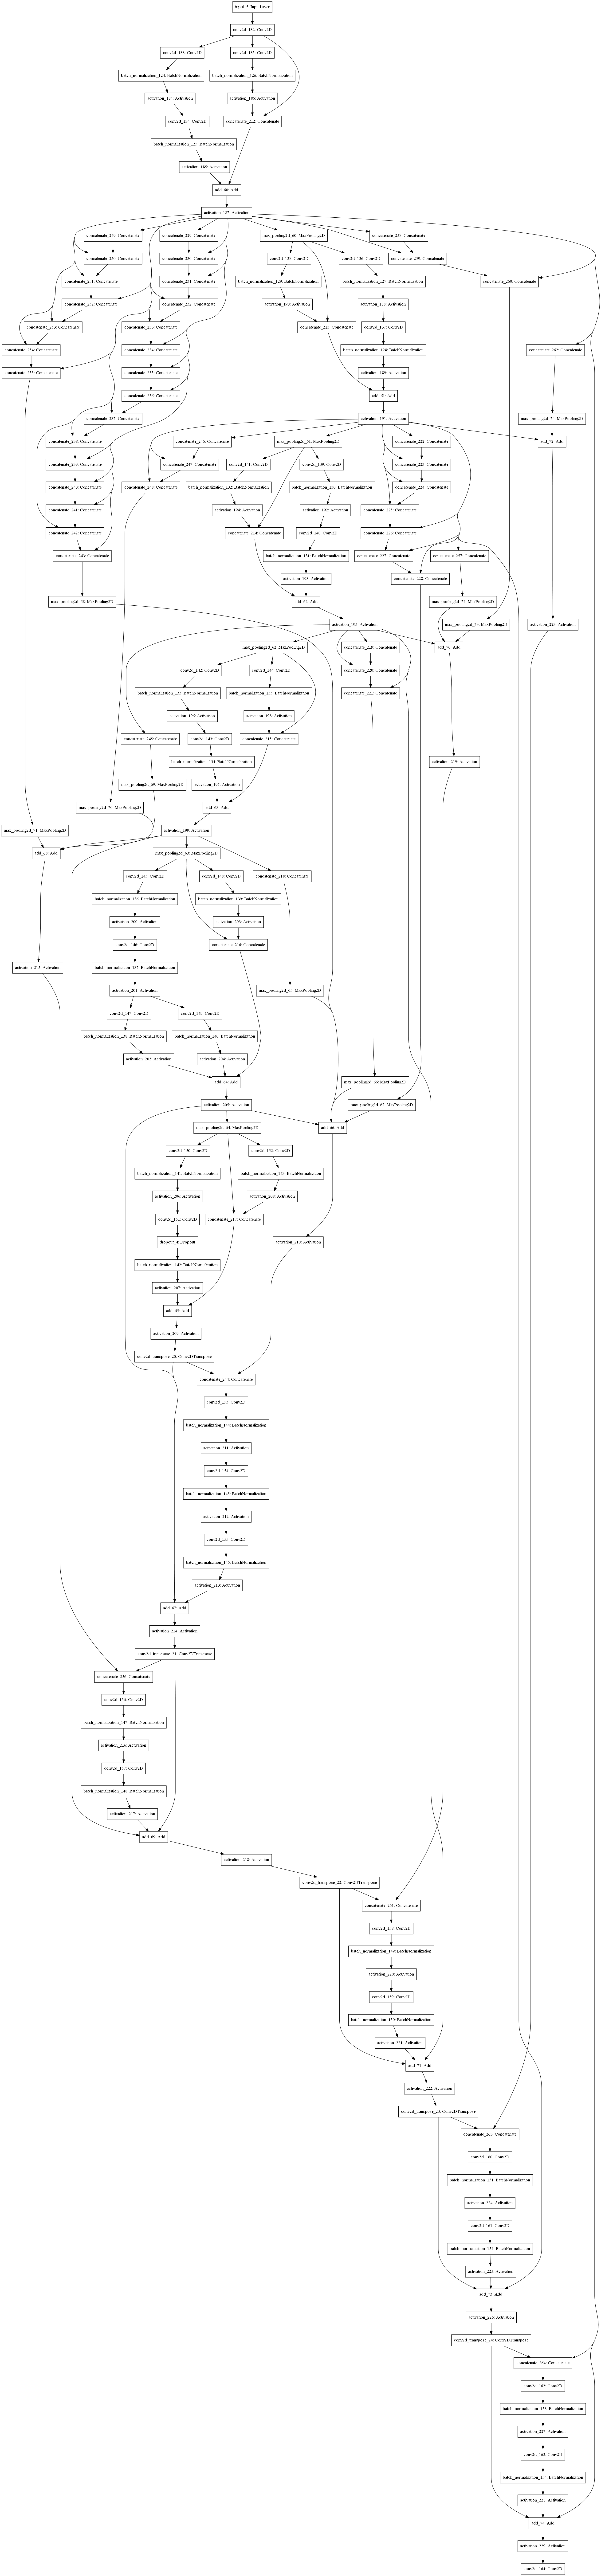

In [16]:
model = model_arch(input_rows=in_rows,
                                       input_cols=in_cols,
                                       num_of_channels=num_of_channels,
                                       num_of_classes=num_of_classes)
model.compile(optimizer=Adam(lr=starting_learning_rate), loss=jacc_coef, metrics=[jacc_coef])

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
#%tensorboard --logdir logs/fit